In [1]:
#importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from prince import FAMD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# setting up plot style 
style.use('seaborn-poster')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)


In [2]:
#import dataset

df = pd.read_csv('satisfaction.csv')
df.drop(columns = 'not_defined', inplace = True)
df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,barreiras,BA,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,vianopolis,GO,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,sao goncalo do amarante,RN,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,santo andre,SP,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92309 entries, 0 to 92308
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_purchase_timestamp       92309 non-null  object 
 1   order_approved_at              92309 non-null  object 
 2   order_delivered_carrier_date   92309 non-null  object 
 3   order_delivered_customer_date  92309 non-null  object 
 4   order_estimated_delivery_date  92309 non-null  object 
 5   customer_city                  92309 non-null  object 
 6   customer_state                 92309 non-null  object 
 7   review_score                   92309 non-null  float64
 8   price                          92309 non-null  float64
 9   freight_value                  92309 non-null  float64
 10  product_category_name          92309 non-null  object 
 11  product_name_lenght            92309 non-null  float64
 12  product_description_lenght     92309 non-null 

# Feature Engineering

## Date Columns

Add columns that are the difference between `order purchase` and anothers date columns

In [4]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

In [5]:
df['diff_approved'] = df['order_approved_at'] - df['order_purchase_timestamp'] #diff data aprovação da compra - data da compra
df['diff_carrier'] = df['order_delivered_carrier_date'] - df['order_purchase_timestamp']
df['diff_customer'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['diff_estimate'] = df['order_estimated_delivery_date'] - df['order_purchase_timestamp']
df['diff_est_del'] = df['order_estimated_delivery_date'] - df['order_delivered_customer_date']

#transforming the values in days difference
df['diff_approved']=df['diff_approved']/np.timedelta64(1,'D')
df['diff_carrier']=df['diff_carrier']/np.timedelta64(1,'D')
df['diff_customer']=df['diff_customer']/np.timedelta64(1,'D')
df['diff_estimate']=df['diff_estimate']/np.timedelta64(1,'D')
df['diff_est_del']=df['diff_est_del']/np.timedelta64(1,'D')

df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,sao paulo,SP,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,barreiras,BA,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,vianopolis,GO,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,sao goncalo do amarante,RN,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,santo andre,SP,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171


In [6]:
#drop date columns
cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date']

df.drop(columns = cols, axis= 1, inplace = True)
df.head()

,customer_city,customer_state,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,sao paulo,SP,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488
1,barreiras,BA,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729
2,vianopolis,GO,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498
3,sao goncalo do amarante,RN,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069
4,santo andre,SP,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92309 entries, 0 to 92308
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_city               92309 non-null  object 
 1   customer_state              92309 non-null  object 
 2   review_score                92309 non-null  float64
 3   price                       92309 non-null  float64
 4   freight_value               92309 non-null  float64
 5   product_category_name       92309 non-null  object 
 6   product_name_lenght         92309 non-null  float64
 7   product_description_lenght  92309 non-null  float64
 8   product_photos_qty          92309 non-null  float64
 9   boleto                      92309 non-null  float64
 10  credit_card                 92309 non-null  float64
 11  debit_card                  92309 non-null  float64
 12  voucher                     92309 non-null  float64
 13  diff_approved               923

## Customer city columns

In [8]:
df['customer_city'].value_counts()

sao paulo               14545
rio de janeiro           6338
belo horizonte           2571
brasilia                 1998
curitiba                 1414
                        ...  
luziapolis                  1
floresta do araguaia        1
douradina                   1
berizal                     1
botelho                     1
Name: customer_city, Length: 3990, dtype: int64

In [9]:
#list of capitals:

capitals = ["rio branco",
"maceio",
"macapa",
"manaus",
"salvador",
"fortaleza",
"brasilia",
"vitria",
"goiania",
"sao luis",
"cuiaba",
"campo grande",
"belo horizonte",
"belem",
"joao pessoa",
"curitiba",
"recife",
"teresina",
"rio de janeiro",
"natal",
"porto alegre",
"porto velho",
"boa vista",
"florianopolis",
"sao paulo",
"aracaju",
"palmas" ]

In [10]:
#create a new column based capitals list
def cap (row):
    if row['customer_city'] in capitals:
        val = 1
    else:
        val = 0
    return val

In [11]:
df['customer_capital'] = df.apply(cap, axis = 1)
df.head()

,customer_city,customer_state,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_capital
0,sao paulo,SP,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488,1
1,barreiras,BA,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,0
2,vianopolis,GO,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,0
3,sao goncalo do amarante,RN,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,0
4,santo andre,SP,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,0


In [12]:
#drop the city column
df.drop(columns = 'customer_city', axis = 1, inplace = True)
df.head()

,customer_state,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_capital
0,SP,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488,1
1,BA,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,0
2,GO,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,0
3,RN,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,0
4,SP,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,0


## Customer State

In [13]:
df.customer_state.value_counts()

SP    38964
RJ    11812
MG    10856
RS     5123
PR     4708
SC     3351
BA     3048
DF     2006
ES     1891
GO     1868
PE     1514
CE     1190
PA      889
MT      857
MS      681
MA      676
PB      485
RN      455
PI      446
AL      379
SE      312
TO      260
RO      227
AM      143
AC       73
AP       61
RR       34
Name: customer_state, dtype: int64

In [14]:
#create a regions list
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
centro_oeste = ['MT', 'MS', 'GO']
sul = ['PR', 'RS', 'SC']
sudeste = ['SP', 'RJ', 'ES', 'MG']

In [15]:
#create a new feature based in region list
def region (row):
    val = ""
    if row['customer_state'] in norte:
        val = 'norte'
    elif row['customer_state'] in nordeste:
        val = 'nordeste'
    elif row['customer_state'] in centro_oeste:
        val = 'centro_oeste'
    elif row['customer_state'] in sul:
        val = 'sul'
    elif row['customer_state'] in sudeste:
        val = 'sudeste'
    return val

In [16]:
df['customer_region'] = df.apply(region, axis = 1)

In [17]:
#drop the customer_state colum
df.drop(columns = 'customer_state', axis = 1, inplace = True)
df.head()

,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_capital,customer_region
0,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488,1,sudeste
1,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,0,nordeste
2,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,0,centro_oeste
3,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,0,nordeste
4,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,0,sudeste


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92309 entries, 0 to 92308
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   review_score                92309 non-null  float64
 1   price                       92309 non-null  float64
 2   freight_value               92309 non-null  float64
 3   product_category_name       92309 non-null  object 
 4   product_name_lenght         92309 non-null  float64
 5   product_description_lenght  92309 non-null  float64
 6   product_photos_qty          92309 non-null  float64
 7   boleto                      92309 non-null  float64
 8   credit_card                 92309 non-null  float64
 9   debit_card                  92309 non-null  float64
 10  voucher                     92309 non-null  float64
 11  diff_approved               92309 non-null  float64
 12  diff_carrier                92309 non-null  float64
 13  diff_customer               923

## Product category

In [19]:
product_percent = df['product_category_name'].value_counts(normalize=True) * 100

In [20]:
products = product_percent[product_percent < 0.5]
products = products.index.tolist()
products

['casa_construcao',
 'alimentos',
 'moveis_sala',
 'casa_conforto',
 'audio',
 'bebidas',
 'livros_tecnicos',
 'market_place',
 'fashion_calcados',
 'climatizacao',
 'industria_comercio_e_negocios',
 'construcao_ferramentas_iluminacao',
 'moveis_cozinha_area_de_servico_jantar_e_jardim',
 'eletrodomesticos_2',
 'alimentos_bebidas',
 'construcao_ferramentas_jardim',
 'telefonia_fixa',
 'artes',
 'pcs',
 'agro_industria_e_comercio',
 'construcao_ferramentas_seguranca',
 'sinalizacao_e_seguranca',
 'artigos_de_natal',
 'fashion_underwear_e_moda_praia',
 'fashion_roupa_masculina',
 'construcao_ferramentas_ferramentas',
 'moveis_quarto',
 'tablets_impressao_imagem',
 'portateis_casa_forno_e_cafe',
 'cine_foto',
 'dvds_blu_ray',
 'livros_importados',
 'artigos_de_festas',
 'moveis_colchao_e_estofado',
 'musica',
 'fashion_roupa_feminina',
 'flores',
 'fashion_esporte',
 'casa_conforto_2',
 'artes_e_artesanato',
 'fraldas_higiene',
 'la_cuisine',
 'cds_dvds_musicais',
 'portateis_cozinha_e_pre

In [21]:
df = df[~df.product_category_name.isin(products)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85769 entries, 0 to 92308
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   review_score                85769 non-null  float64
 1   price                       85769 non-null  float64
 2   freight_value               85769 non-null  float64
 3   product_category_name       85769 non-null  object 
 4   product_name_lenght         85769 non-null  float64
 5   product_description_lenght  85769 non-null  float64
 6   product_photos_qty          85769 non-null  float64
 7   boleto                      85769 non-null  float64
 8   credit_card                 85769 non-null  float64
 9   debit_card                  85769 non-null  float64
 10  voucher                     85769 non-null  float64
 11  diff_approved               85769 non-null  float64
 12  diff_carrier                85769 non-null  float64
 13  diff_customer               857

In [22]:
df.product_category_name.value_counts()

cama_mesa_banho                      9116
beleza_saude                         8188
esporte_lazer                        7147
informatica_acessorios               6220
moveis_decoracao                     6090
utilidades_domesticas                5393
relogios_presentes                   5179
telefonia                            3758
automotivo                           3621
brinquedos                           3606
cool_stuff                           3298
ferramentas_jardim                   3259
perfumaria                           2963
bebes                                2616
eletronicos                          2331
papelaria                            2186
fashion_bolsas_e_acessorios          1789
pet_shop                             1624
no info                              1323
moveis_escritorio                    1103
malas_acessorios                      966
consoles_games                        926
eletrodomesticos                      721
construcao_ferramentas_construcao 

# Model

Text(0.5, 1.0, 'Correlation Heatmap')

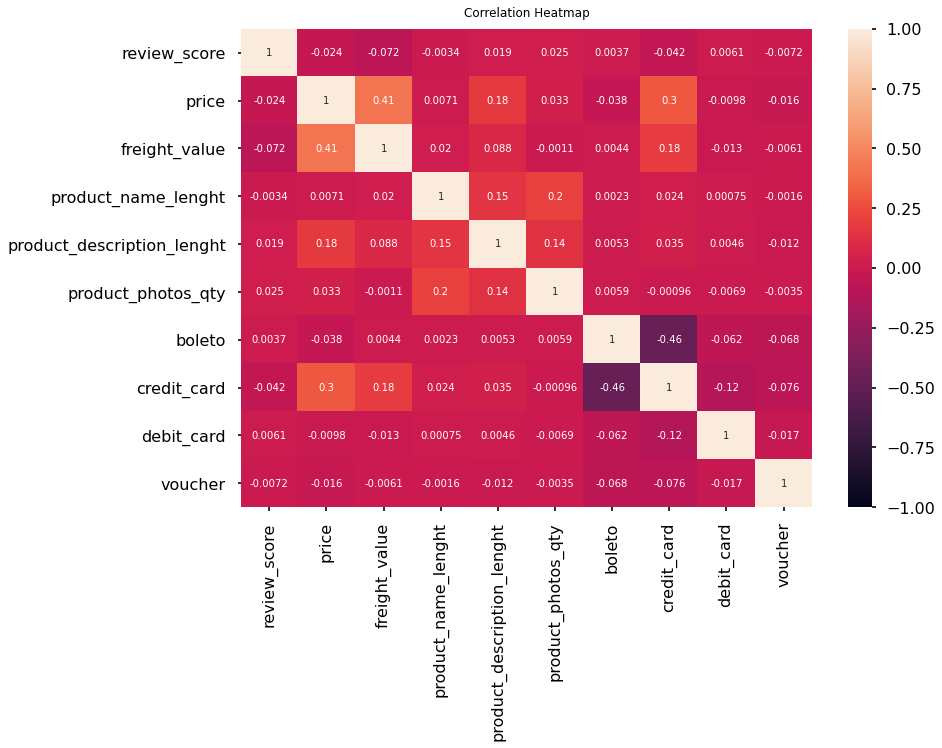

In [23]:
heatmap = sns.heatmap(df.iloc[:,0:11].corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [25]:
df.head()

,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_capital,customer_region
0,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488,1,sudeste
1,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,0,nordeste
2,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,0,centro_oeste
3,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,0,nordeste
4,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,0,sudeste


In [28]:
df.columns

Index(['review_score', 'price', 'freight_value', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'boleto', 'credit_card', 'debit_card', 'voucher', 'diff_approved', 'diff_carrier', 'diff_customer', 'diff_estimate', 'diff_est_del', 'customer_capital', 'customer_region'], dtype='object')

## Applying FAMD

In [37]:
famd = FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)

famd.fit(df)
famd_components = famd.transform(df)
famd_components


,0,1
0,-1.416773,-0.042684
1,0.855315,1.486156
2,0.562498,-0.436008
3,1.012872,-0.629774
4,-1.626743,-0.758094
...,...,...
92303,-0.278529,-0.785311
92304,-0.753896,-0.703528
92305,0.034195,-0.423638
92307,1.142434,-0.307670


In [35]:
ax = famd.plot_row_coordinates(
    df,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    labels = df['review_score'],
    color_labels=['Região {}'.format(t) for t in df['customer_region']],
    ellipse_outline=False,
    ellipse_fill=True,
    show_points=True
)



C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x0000027CC1762700> (for post_execute):



KeyboardInterrupt



Text(0, 0.5, 'Inertia')

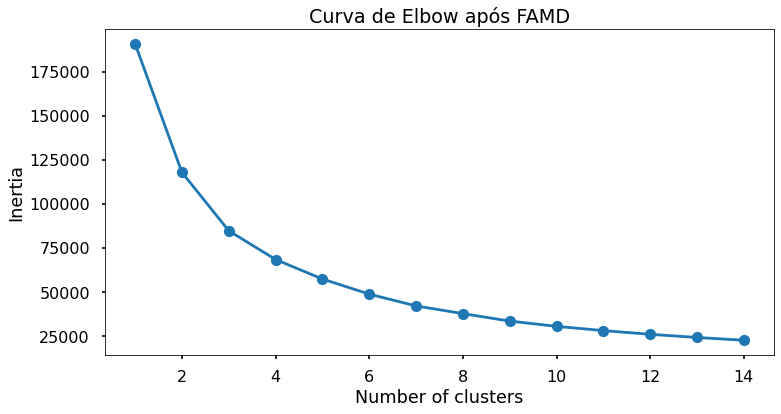

In [38]:

sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(famd_components)
    sse.append([k, km.inertia_])
    
famd_n_cluster = pd.DataFrame({'n_cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Curva de Elbow após FAMD')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [39]:
#applying kmeans in FAMD components

kmeans_famd = KMeans(n_clusters=5, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(famd_components)

print('KMeans - FAMD Silhouette Score: {}'.format(silhouette_score(famd_components, kmeans_famd.labels_, metric='euclidean')))
labels_famd = kmeans_famd.labels_
clusters_famd = pd.concat([famd_components, pd.DataFrame({'famd_clusters':labels_famd})], axis=1)

KMeans - FAMD Silhouette Score: 0.3279215445944996


In [48]:
clusters_famd.head()

,0,1,famd_clusters
0,-1.416773,-0.042684,0.0
1,0.855315,1.486156,4.0
2,0.562498,-0.436008,3.0
3,1.012872,-0.629774,3.0
4,-1.626743,-0.758094,0.0


In [44]:
clusters_famd.iloc[:,0]

0       -1.416773
1        0.855315
2        0.562498
3        1.012872
4       -1.626743
           ...   
92303   -0.278529
92304   -0.753896
92305    0.034195
92307    1.142434
92308    0.184413
Name: 0, Length: 91814, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


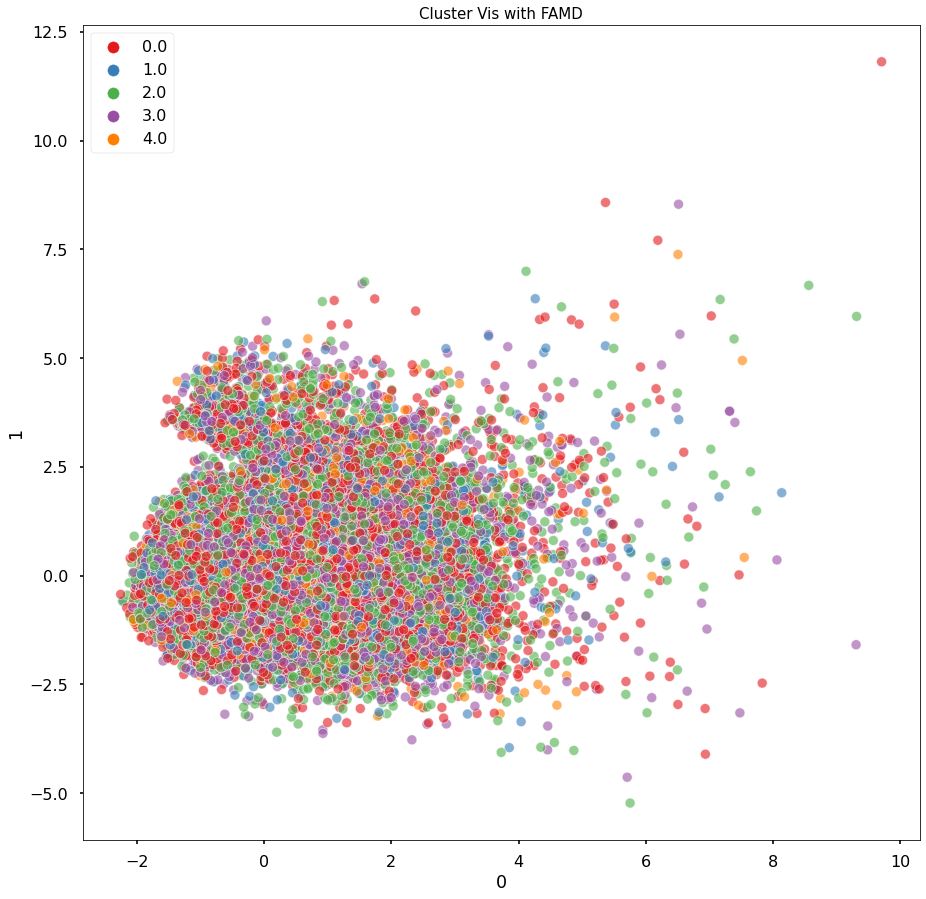

In [50]:
plt.figure(figsize = (15,15))
sns.scatterplot(clusters_famd.iloc[:,0],clusters_famd.iloc[:,1],hue=clusters_famd['famd_clusters'], 
                palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis with FAMD', fontsize=15)
plt.legend()
plt.show()